In [7]:

# importing packages

%matplotlib notebook
import matplotlib.pyplot as plt;
plt.style.use('classic')
import numpy as np
from pyDOE import lhs #<-- Latin hypercube

import random
from scipy.interpolate import griddata


from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import initializers

import tensorflow as tf

In [2]:
# importing data as numpy arrays
time=np.load("tt.npy")
zz=np.load("zz.npy")

In [3]:
# more numpy arrays
X0=np.load("X0.npy")
Y0=np.load("Y0.npy")
Bav=np.load("Bav.npy")

# variables to define shape of said arrays
X1=np.zeros(np.shape(X0))
Y1=np.zeros([len(Y0),1])

# normalizing data to help reduce time of rendering
X1[:,0]=(X0[:,0]-np.mean(X0[:,0]))/np.std(X0[:,0])
X1[:,1]=(X0[:,1]-np.mean(X0[:,1]))/np.std(X0[:,1])


Y1[:,0]=(Y0-np.mean(Y0))/np.std(Y0)


# Arrange data to be evenly spaced
myindex=np.arange(0,len(X1))
np.random.shuffle(myindex)

X0=X0[myindex,:]
Y0=Y0[myindex]

X1=X1[myindex,:]
Y1=Y1[myindex,:]

<IPython.core.display.Javascript object>


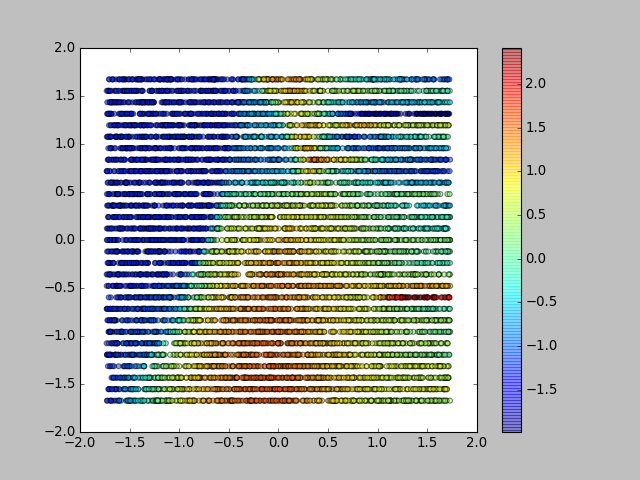

In [4]:
# plotting the data
NN=10000
list_of_random = random.sample(list(myindex), NN)


plt.figure(123);plt.clf()
plt.scatter(X1[list_of_random,0],X1[list_of_random,1],c=Y1[list_of_random,0],cmap='jet',alpha=0.5,marker='o')

plt.colorbar()
#plt.clim(-1,1)

In [5]:
Y1.shape

(145000, 1)

In [6]:
span=10

X11=np.zeros([len(X1),2*span])
Y11=np.zeros(np.shape(X11))

print(X11)
print(Y11)

for jj in range(0,span):
    X11[:,2*jj:2*jj+2]=X1
    Y11[:,2*jj]=Y1[:,0]
    Y11[:,2*jj+1]=Y1[:,0]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [7]:
from keras import backend as K
def swish(x):
    return x * K.sigmoid(x)

# Where did you get these constants for loss function?

def swishn(x):
    return 1.78718727865 * (x * K.sigmoid(x) - 0.20662096414)

In [8]:
myActiv='relu'
# myActiv='softplus'
#myActiv='elu'
#myActiv=swishn
#myActiv='selu'
myNumInner=30

# batch size? (smaller for more datasets and)
myWinner=10#span*2

#myInit=initializers.Orthogonal(gain=1.0, seed=None)
#myInit=initializers.he_uniform(seed=None)
#myInit=initializers.he_normal(seed=None)
#myInit=initializers.lecun_uniform(seed=None)

#myInit=initializers.lecun_normal(seed=None)

#myInit=initializers.RandomNormal(mean=0.0, stddev=1.0e-4, seed=None)
myInit=initializers.glorot_normal(seed=None)
# define the keras model
#myInit="normal"
model = Sequential()

Bias_yes=True
#model.add(Dense(myWinner, input_dim=10, activation='linear',kernel_initializer=initializers.Constant(value=np.sqrt(50)/myWinner)))
#model.add(Dense(myWinner, input_dim=span*2, activation='linear',kernel_initializer=myInit,use_bias=Bias_yes))
model.add(Dense(myWinner, input_dim=2, activation='linear',kernel_initializer=myInit,use_bias=Bias_yes))
for jj in range(0, myNumInner-1):
    model.add(Dense(myWinner, activation=myActiv,kernel_initializer=myInit,use_bias=Bias_yes))

#model.add(Dense(myWinner, activation='linear',kernel_initializer=myInit))
#model.add(Dense(1, activation='linear',kernel_initializer=myInit))        
#model.add(Dense(1, activation='linear',kernel_initializer=initializers.Constant(value=1/myWinner)))
#model.add(Dense(span*2, activation='linear',kernel_initializer=myInit,use_bias=Bias_yes))
model.add(Dense(1, activation='linear',kernel_initializer=myInit,use_bias=Bias_yes))

model.summary()

big_history=np.array([])

print(big_history)



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

In [9]:
# Receiving values for weights of layers?

W,L =model.layers[0].get_weights()

In [10]:
print(np.sum(W[:,6]**2))

print(np.sum(W[:,2])/(2*span))

0.16076145
-0.009538191556930541


In [11]:
# Actual model compiling

myLR=0.001
my_optimizer=optimizers.Adam(lr=myLR, beta_1=0.9, beta_2=0.999, amsgrad=True)
#my_optimizer=optimizers.RMSprop(lr=0.00002, rho=0.9)
#my_optimizer=optimizers.Adadelta(lr=1.0, rho=0.95)
#my_optimizer=optimizers.SGD(lr=2e-3, momentum=0.01, nesterov=False)
model.compile(loss='mse', optimizer=my_optimizer, metrics=['mse'])
#loss = tf.keras.losses.Huber(delta=1.0)
#model.compile(loss='huber', optimizer=my_optimizer, metrics=['accuracy'])
#model.compile(loss='mae', optimizer=my_optimizer, metrics=['accuracy'])
#model.compile(loss=loss, optimizer=my_optimizer, metrics=['mean_absolute_error'])
#model.compile(loss='logcosh', optimizer=my_optimizer, metrics=['accuracy'])


In [15]:
## fit the keras model on the dataset
#model.fit(Xall, Yall, epochs=10000, batch_size=int(len(Xall)/4),shuffle=True)
#model.fit(Xf, Yf, epochs=1000, batch_size=int(len(Xf/2)),shuffle=True)#
history=model.fit(X1, Y1, epochs=500, batch_size=5000,shuffle=True,validation_split=0.05)

big_history=np.hstack([big_history,history.history['loss']])

Train on 137750 samples, validate on 7250 samples
Epoch 1/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 2/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0203 - val_mse: 0.0203
Epoch 3/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 4/500
137750/137750 [==============================] - 1s 8us/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 5/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 6/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 7/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.

137750/137750 [==============================] - 1s 9us/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 118/500
137750/137750 [==============================] - 1s 8us/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 119/500
137750/137750 [==============================] - 1s 10us/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 120/500
137750/137750 [==============================] - 1s 11us/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 121/500
137750/137750 [==============================] - 1s 10us/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 122/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 123/500
137750/137750 [==============================] - 1s 10us/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 124/500
137750/13

137750/137750 [==============================] - 1s 11us/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 176/500
137750/137750 [==============================] - 2s 12us/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 177/500
137750/137750 [==============================] - 3s 19us/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 178/500
137750/137750 [==============================] - 2s 13us/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 179/500
137750/137750 [==============================] - 2s 12us/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 180/500
137750/137750 [==============================] - 2s 13us/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 181/500
137750/137750 [==============================] - 2s 12us/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 182/500
137750

137750/137750 [==============================] - 1s 10us/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 234/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 235/500
137750/137750 [==============================] - 1s 10us/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 236/500
137750/137750 [==============================] - 1s 8us/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 237/500
137750/137750 [==============================] - 1s 8us/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 238/500
137750/137750 [==============================] - 2s 13us/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 239/500
137750/137750 [==============================] - 2s 12us/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 240/500
137750/13

Epoch 291/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 292/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 293/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 294/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 295/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 296/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 297/500
137750/137750 [==============================] - 2s 11us/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 298/50

Epoch 349/500
137750/137750 [==============================] - 2s 12us/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 350/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 351/500
137750/137750 [==============================] - 1s 10us/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 352/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 353/500
137750/137750 [==============================] - 1s 8us/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 354/500
137750/137750 [==============================] - 1s 8us/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 355/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 356/5

137750/137750 [==============================] - 1s 9us/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 408/500
137750/137750 [==============================] - 1s 10us/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 409/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 410/500
137750/137750 [==============================] - 2s 11us/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 411/500
137750/137750 [==============================] - 2s 11us/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 412/500
137750/137750 [==============================] - 2s 11us/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 413/500
137750/137750 [==============================] - 2s 11us/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 414/500
137750/1

137750/137750 [==============================] - 2s 15us/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 466/500
137750/137750 [==============================] - 1s 8us/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 467/500
137750/137750 [==============================] - 1s 8us/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 468/500
137750/137750 [==============================] - 1s 8us/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 469/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 470/500
137750/137750 [==============================] - 1s 10us/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 471/500
137750/137750 [==============================] - 1s 9us/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 472/500
137750/1377

In [16]:
# Saves model to specific file
model.save("Baverage5")

<IPython.core.display.Javascript object>


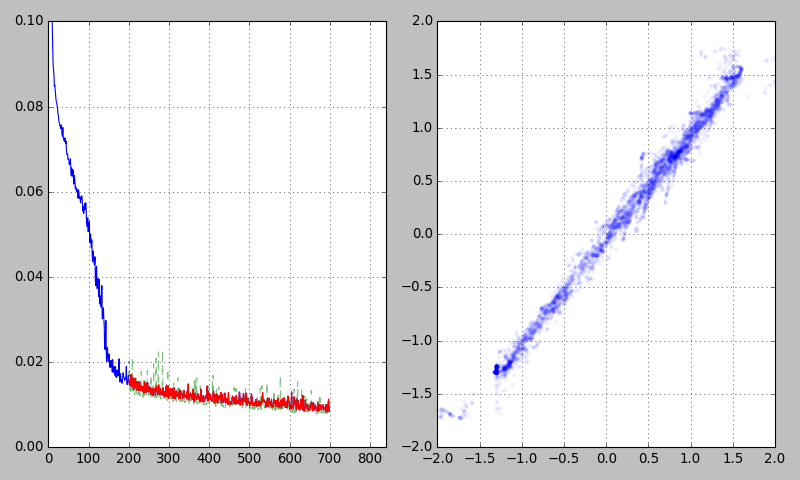

In [17]:
plt.figure(44,figsize=(10,6));plt.clf()
plt.subplot(1,2,1)

xlims1=(0,len(big_history)*1.2)
bbb=np.arange(0,len(history.history['loss']))


plt.plot(big_history)
plt.plot(bbb+len(big_history)-len(bbb),(history.history['val_loss']),'--',alpha=0.5)

plt.plot(bbb+len(big_history)-len(bbb),(history.history['loss']),'-')

plt.plot(0,0)
ymax=0.1
indsel=np.random.randint(0,len(X11),6000)

#Y_pred = np.mean(model.predict(X11[indsel,:]),axis=1)
#mumj=0
Y_pred = model.predict(X1[indsel,:])


#print(Yf[indsel[mumj],:])
plt.xlim(xlims1)

plt.ylim(0,ymax)
plt.grid()

#plt.plot(0,0)
plt.subplot(1,2,2)

plt.plot(Y1[indsel],Y_pred,'.',alpha=0.05)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()
plt.tight_layout()


In [20]:
numnum=128

expand=1.0
xcent=0.0
ycent=0.0
#xrange=expand*np.array([xmin-xcent,xmax-xcent])
#trange=expand*np.array([tmin-ycent,tmax-ycent])

#xrange=(np.array([xmin-xcent,xmax-xcent])-meanXf)/stdXf
#trange=(np.array([tmin-ycent,tmax-ycent])-meanXf)/stdXf
xrange=np.array([np.min(X11[:,1]),np.max(X11[:,1])])
trange=np.array([np.min(X11[:,0]),np.max(X11[:,0])])

xx=expand*np.linspace(xrange[0]-xcent,xrange[1]-xcent,numnum)
tt=expand*np.linspace(trange[0]-ycent,trange[1]-ycent,numnum)

T,X = np.meshgrid(tt,xx)
X_star = np.hstack((T.flatten()[:,None],X.flatten()[:,None]))

X_star2=np.zeros([len(X_star),2*span])


for jj in range(0,span):
    X_star2[:,2*jj:2*jj+2]=X_star
#Y_star = np.mean(model.predict(X_star2),axis=1)
Y_star = model.predict(X_star)

Yp=np.zeros([numnum,numnum])
Yp=griddata(X_star, Y_star.flatten(), (T,X), method='cubic')

Yp[:,:]=Yp[::-1,:]

<IPython.core.display.Javascript object>


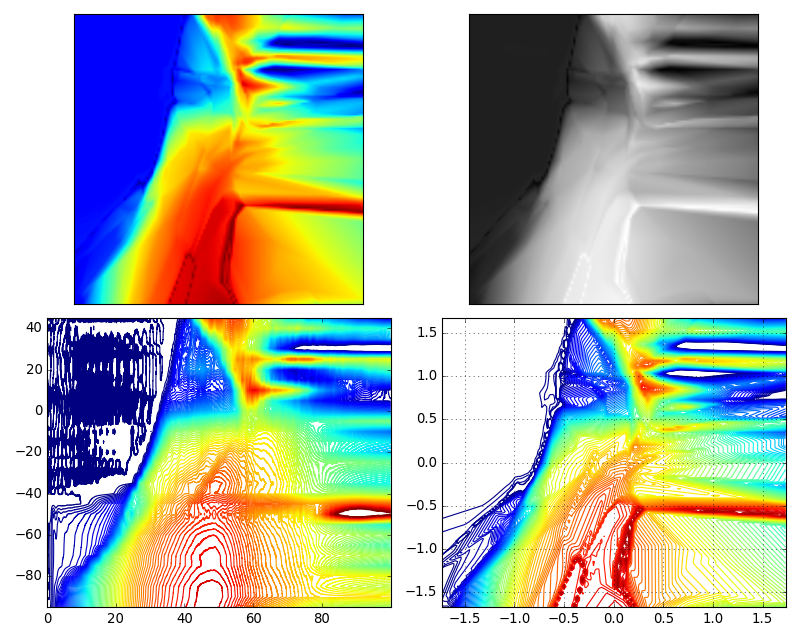

In [21]:
plt.figure(13,facecolor='none',figsize=(10,8));plt.clf()

plt.subplot(2,2,1)
#levels=np.linspace(plo.min(),plo.max(),251)

plt.imshow(Yp)
#plt.contour(xx,tt,plo.T,100,cmap='gray')
#fac=0.7
#plt.clim(fac*np.min(Yf),fac*np.max(Yf))
#plt.grid(color='white')
#plt.clim(0,2)
plt.xticks([])
plt.yticks([])


plt.subplot(2,2,2)

plt.imshow(Yp,cmap='gray')

plt.xticks([])
plt.yticks([])

plt.subplot(2,2,3)
levels=np.linspace(0,700,101)
plt.contour(time[1000:6000],zz,Bav,levels)
#plt.xticks([])
#plt.yticks([])


plt.subplot(2,2,4)
#levels=np.linspace(-2,2,51)
#plt.contour(tt*np.std(X0[:,0])+np.mean(X0[:,0]),xx*np.std(X0[:,1])+np.mean(X0[:,1]),Yp[::-1,:]*np.std(Y0)+np.mean(Y0),levels)
plt.contour(tt,xx,Yp[::-1,:]*np.std(Y0)+np.mean(Y0),levels)

lilx=np.linspace(-0.1,0.1,10)
#plt.plot(lilx,mmm*lilx)
#plt.xticks([])
#plt.yticks([])
plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


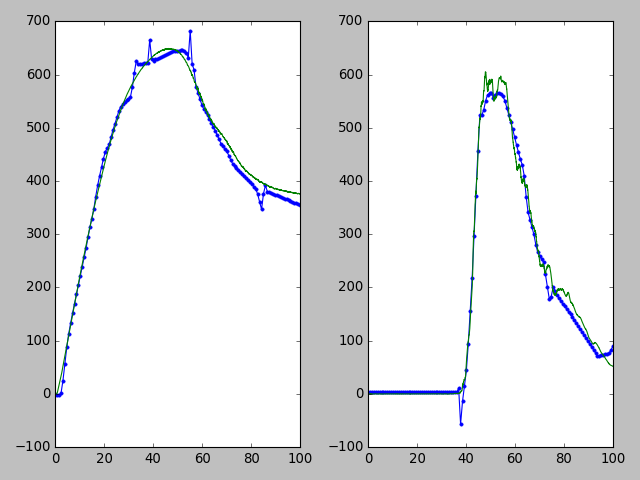

In [22]:
plt.figure(1232);plt.clf()

plt.subplot(1,2,1)
plt.plot(tt*np.std(X0[:,0])+np.mean(X0[:,0]),Yp[-1,:]*np.std(Y0)+np.mean(Y0),'.-')
plt.plot(time[1000:6000],Bav[0,:])


plt.subplot(1,2,2)
plt.plot(tt*np.std(X0[:,0])+np.mean(X0[:,0]),Yp[0,:]*np.std(Y0)+np.mean(Y0),'.-')
plt.plot(time[1000:6000],Bav[-1,:])

plt.tight_layout()

In [ ]:

x_test_1 = np.zeros([500,2])
x_test_1[:,1]=0.87
x_test_1[:,0]=np.linspace(-1,0,500)

In [ ]:
gradients = K.gradients(model.output, model.input)              #Gradient of output wrt the input of the model (Tensor)
print(gradients)

sess = K.get_session()

e_g_1 = sess.run(gradients[0], feed_dict={model.input: x_test_1})
#print(e_g_1)
#mmm=-e_g_1[0,0]/e_g_1[0,1]



In [ ]:

mvec=-e_g_1[:,0]/e_g_1[:,1]

plt.figure(1232111);plt.clf()

plt.plot(x_test_1[:,0],mvec,'-')
plt.plot(x_test_1[:,0],e_g_1[:,0],'-')
plt.plot(x_test_1[:,0],e_g_1[:,1],'-')

plt.ylim(-10,10)
plt.grid()
